# Day 4 Solutions

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [22]:
# working with the classes
# NFW  --> delta_sigma
class constants:
    """Useful constants"""
    G     = 4.301e-9    #km^2 Mpc M_sun^-1 s^-2 gravitational constant
    H0    = 100.       #h kms-1 Mpc-1 hubble constant at present
    omg_m = 0.315   #omega_matter

class halo(constants):
    """Useful functions for weak lensing signal modelling"""
    
    def __init__(self, log_M200m, con_par):
        self.m_tot   = 10**log_M200m # h-1 Msun
        self.c       = con_par # concentration parameter
        
        self.rho_crt = 3 * self.H0**2 /(8.0*np.pi*self.G) # rho critical
        
        self.r_200   = (3 * self.m_tot /(4*np.pi*200*self.rho_crt*self.omg_m))**(1./3.) # Mpc h-1
        self.rho_0   = self.c**3 * self.m_tot/(4 * np.pi * self.r_200**3 *(np.log(1 + self.c) - self.c/(1 + self.c)))
        #print("log_M200m = %s h-1 M_sun, c = %s \n"%(np.log10(self.m_tot), self.c))
        
    def nfw(self,r):
        """given r, this gives nfw profile as per the instantiated parameters"""      
        r_s    = self.r_200/self.c
        value  = self.rho_0/((r/r_s)*(1+r/r_s)**2)
        return value
    
    def sigma_nfw(self,r):
        """analytical projection of NFW"""
        r_s = self.r_200/self.c
        k   = 2*r_s*self.rho_0
        sig = 0.0*r
        c = 0
        for i in r:
            x = i/r_s
            if x < 1:
                value = (1 - np.arccosh(1/x)/np.sqrt(1-x**2))/(x**2-1)
            elif x > 1:
                value = (1 - np.arccos(1/x)/np.sqrt(x**2-1))/(x**2-1)
            else:
                value = 1./3.
            sig[c] = value*k
            c=c+1
        return sig
    
    def avg_sigma_nfw(self,r):           
        """analytical average projected of NFW"""
        r_s  = self.r_200/self.c
        k    = 2*r_s*self.rho_0
        sig  = 0.0*r
        c=0
        for i in r:
            x = i/r_s
            if x < 1:
                value = np.arccosh(1/x)/np.sqrt(1-x**2) + np.log(x/2.0)
                value = value*2.0/x**2
            elif x > 1:
                value = np.arccos(1/x)/np.sqrt(x**2-1)  + np.log(x/2.0)
                value = value*2.0/x**2
            else:
                value = 2*(1-np.log(2))
            sig[c] = value*k
            c=c+1
        return sig
        
    def esd(self,r): 
        """ESD profile from analytical predictions"""
        val = self.avg_sigma_nfw(r) - self.sigma_nfw(r)
        return val

    


In [23]:
hp = halo(14,5)

In [24]:
print(np.log10(hp.m_tot), hp.c, np.log10(hp.rho_crt), hp.r_200, np.log10(hp.rho_0))

14.0 5 11.443311952479494 1.1093952351546374 14.880882611979143


Text(0, 0.5, '$\\rho(r)$')

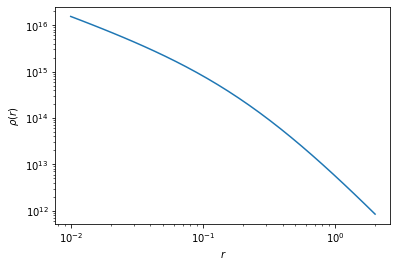

In [25]:
rbin = np.logspace(-2,np.log10(2),30)
plt.plot(rbin, hp.nfw(rbin), '-')

# plt.plot(rbin, hp.esd(rbin)/(1e12), '-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$')
plt.ylabel(r'$\rho(r)$')
# plt.ylabel(r'$\Delta \Sigma (R) [{\rm h M_\odot pc^{-2}}]$')

Text(0, 0.5, '$\\Sigma (R)$')

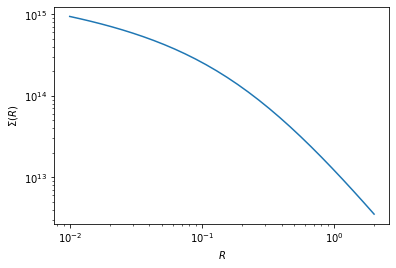

In [26]:
rbin = np.logspace(-2,np.log10(2),30)
plt.plot(rbin, hp.sigma_nfw(rbin), '-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$R$')
plt.ylabel(r'$\Sigma (R)$')

Text(0, 0.5, '$\\Delta \\Sigma (R)$')

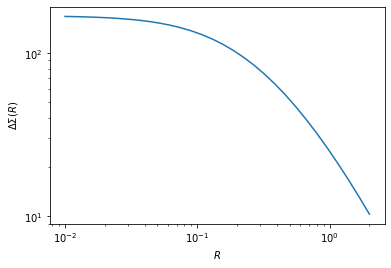

In [27]:
rbin = np.logspace(-2,np.log10(2),30)
plt.plot(rbin, hp.esd(rbin)/(1e12), '-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$R$')
plt.ylabel(r'$\Delta \Sigma (R)$')

In [28]:
def model(x, log_M200m, c):
    log_M200m = np.log10(log_M200m) + 14 # we are looking in units of 10^14
    hp = halo(log_M200m, c);
    esd = hp.esd(x)/1e12 # remember we are working with pc not Mpc
    return esd


In [29]:
print(model(np.linspace(0.2,2.0,5), 13, 6))

[392.98477752 216.4730308  138.35991084  97.34318514  72.89303872]


In [30]:
from scipy.optimize import curve_fit

In [31]:
data = np.loadtxt('/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/iagrg_dsigma.dat')
x    = data[:,0]
y    = data[:,1]
yerr = data[:,2]

<ipython-input-28-d986e37204cc>:2: RuntimeWarning: invalid value encountered in log10
  log_M200m = np.log10(log_M200m) + 14 # we are looking in units of 10^14


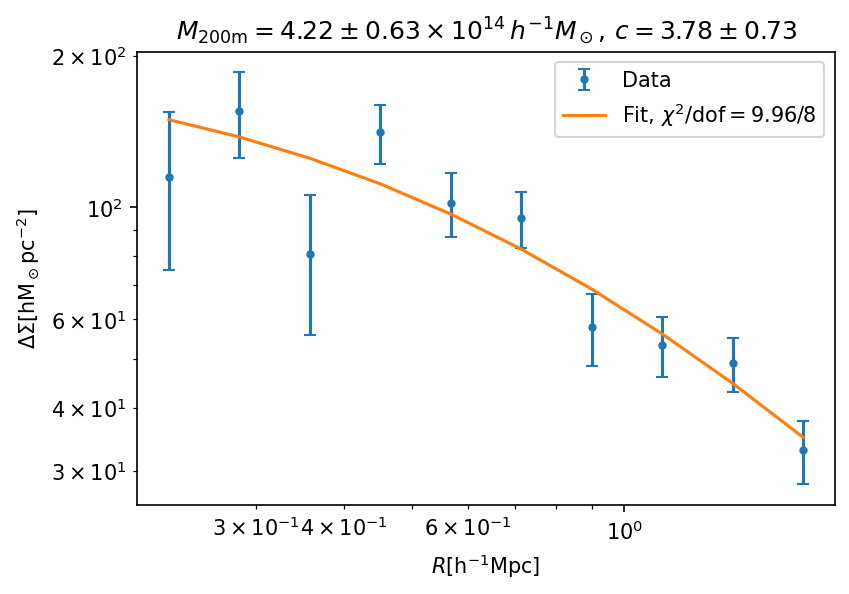

In [32]:
plt.figure(dpi=150)
# curve_fit requires initial guess (p0) to get resonable fits, sigma takes in the y errobars 
popt, pcov = curve_fit(model, x, y, p0=[12,0.5], sigma=yerr)

log_M200m, c = popt
sig_logMh, sig_c = np.sqrt(np.diag(pcov)) # pcov is the covariance between the parameters

# rough estimate of chisq
chisq = np.sum((y-model(x, log_M200m, c))**2*1.0/yerr**2)
dof = 10 - 2 # 10 datapoints - 2 parameters
plt.errorbar(x, y, yerr=yerr, fmt='.', capsize=3, label='Data')
plt.errorbar(x, model(x, log_M200m, c) , fmt='-', label=r'Fit, $\chi^2 /{\rm dof} = %2.2f/%d$'%(chisq,dof))

plt.title(r'$M_{\rm 200m} = %2.2f \pm %2.2f \times 10^{14} \,h^{-1} M_\odot,\, c = %2.2f \pm %2.2f$'%(log_M200m, sig_logMh, c, sig_c))
plt.legend()
plt.xlabel(r'$R[{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$\Delta\Sigma [{\rm h M_\odot pc^{-2}}]$')
plt.xscale('log')
plt.yscale('log')

When we compare our halo masses with the ones using SDSS shape catalog [arXiv:1707.01907](https://arxiv.org/abs/1707.01907), we found that within the error bars our results are in agreement with the reported ones as given in subpanels of fig 4 and fig 5 in [arXiv:1707.01907](https://arxiv.org/abs/1707.01907).



